# Problem 2 – Yield Curve Construction and Swap Valuation

Assume: 
- The year consists of 12 months each with exactly 30 days 
- ALl payments occur at the end of day on the last day of the month
- No credit risk and the the principal of all bonds is 100. 

**Today:** 2019-12-30. **Known fixings:** 3M LIBOR = 0.01570161, 6M LIBOR = 0.01980204.

Bonds (coupon paid simple at stated frequency, principal 100):
1) Price 102.33689177, quarterly 4%, maturity 2020-12-30
2) Price 104.80430234, semiannual 5%, maturity 2020-12-30
3) Price 105.1615306,  semiannual 5%, maturity 2021-06-30
4) Price 105.6581905,  quarterly 6%,  maturity 2021-06-30
5) Price 104.028999992, quarterly 5%, maturity 2021-12-30
6) Price 101.82604116,  annual 3%,   maturity 2021-12-30

We generate coupon schedules from 2019-12-30 to each maturity with end-of-month payments and 30/360 accruals. We include principal at maturity. The cashflow matrix has one column per unique payment date across all bonds; entries are the cashflows on that date (coupon + principal if maturity).

## a) Cashflow matric 

Build the **cashflow matrix** for the given fixed-rate bullet bonds (using the exact coupon schedules).


In [1]:
import numpy as np
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta

# Inputs from the problem description
today = date(2019,12,30)
principal = 100.0

# Bonds: (price, annual_coupon_rate, freq_per_year, maturity_date)
bonds = [
    (102.33689177, 0.04, 4, date(2020,12,30)),  # quarterly 4%
    (104.80430234, 0.05, 2, date(2020,12,30)),  # semiannual 5%
    (105.1615306 , 0.05, 2, date(2021, 6,30)),  # semiannual 5%
    (105.6581905 , 0.06, 4, date(2021, 6,30)),  # quarterly 6%
    (104.028999992,0.05, 4, date(2021,12,30)),  # quarterly 5%
    (101.82604116, 0.03, 1, date(2021,12,30)),  # annual 3%
]

# Build coupon payment schedule: - With start: issue date, end: maturity, freq: payments per year
# Returns all coupon dates at end-of-month until maturity. 
def build_schedule(start, end, freq):
    """Coupon dates at end-of-month until maturity."""
    step = 12 // freq
    dates = []
    d = start
    while True:
        # go forward 'step' months and snap to end-of-month
        d = (d + relativedelta(months=step)).replace(day=30)
        dates.append(d)
        if d >= end.replace(day=30):  # maturity also treated as day 30
            break
    return dates

def year_frac_30_360(d0, d1):
    """30/360 day-count fraction between d0 and d1."""
    return ((d1.year - d0.year) * 360 + (d1.month - d0.month) * 30 + (d1.day - d0.day)) / 360.0

# Build schedules for each bond  
schedules = [build_schedule(today, mat, f) for _,_,f,mat in bonds]
# Collect all unique payment dates across all bonds 
all_dates = sorted(set([d for sch in schedules for d in sch]))

#  Build cashflow matrix 
T = np.array([year_frac_30_360(today, d) for d in all_dates])

A = np.zeros((len(bonds), len(all_dates)))
for j, (_, c, f, _) in enumerate(bonds):
    sch = schedules[j]
    coupon = principal * c / f
    for d in sch:
        col = all_dates.index(d)
        A[j, col] += coupon
        if d == sch[-1]:   # add principal at maturity
            A[j, col] += principal

#  Display results 
A_df = pd.DataFrame(A, columns=[d.isoformat() for d in all_dates],
                    index=[f"Bond {i+1}" for i in range(len(bonds))])
display(A_df.round(2))

,2020-03-30,2020-06-30,2020-09-30,2020-12-30,2021-03-30,2021-06-30,2021-09-30,2021-12-30
Bond 1,1.00,1.00,1.00,101.00,0.00,0.00,0.00,0.00
Bond 2,0.00,2.50,0.00,102.50,0.00,0.00,0.00,0.00
Bond 3,0.00,2.50,0.00,2.50,0.00,102.50,0.00,0.00
Bond 4,1.50,1.50,1.50,1.50,1.50,101.50,0.00,0.00
Bond 5,1.25,1.25,1.25,1.25,1.25,1.25,1.25,101.25
Bond 6,0.00,0.00,0.00,3.00,0.00,0.00,0.00,103.00


## b) Find zero-coupon prices 
(Find the vector of zero coupon prices for all the times that you can based on the above information
and find the term structure of continuously compounded zero coupon spot rates (the yield curve).
Report the results and plot both curves in an appropriate diagram.)

Solve for **zero-coupon prices** \(p(0,T)\) on all reachable payment dates and compute the **continuously compounded spot rates** \(R(T) = -\ln p(0,T)/T\).


In [2]:
import matplotlib.pyplot as plt


,date,T_years_30_360,DF,spot_cc
0,2020-03-30,0.25,0.996090,0.015671
1,2020-06-30,0.50,0.990196,0.019705
2,2020-09-30,0.75,-0.480712,36.841361
3,2020-12-30,1.00,0.998330,0.001672
4,2021-03-30,1.25,1.793056,-0.467137
5,2021-06-30,1.50,0.977466,0.015195
6,2021-09-30,1.75,0.227268,0.846644
7,2021-12-30,2.00,0.959525,0.020659


Check DF constraints at 3M and 6M:
  p(0,3M): target=0.99608995 | solved=0.99608995 | date=2020-03-30
  p(0,6M): target=0.99019605 | solved=0.99019605 | date=2020-06-30


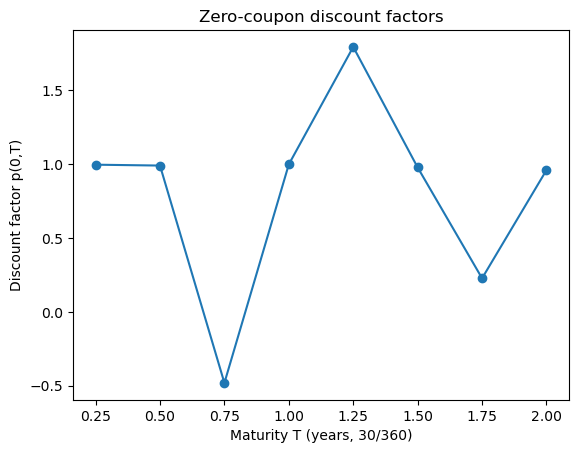

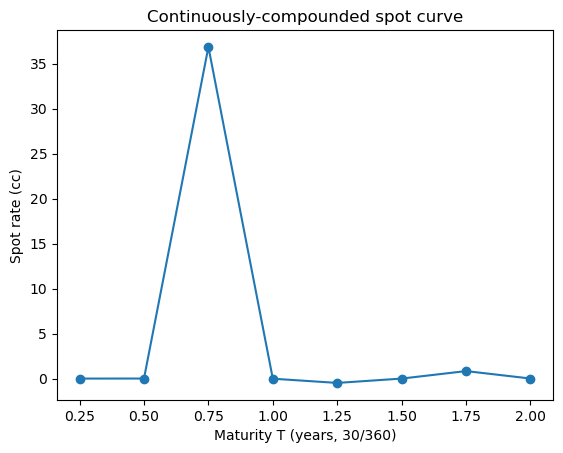

In [3]:
# Run a) before this!
%matplotlib inline 

import matplotlib.pyplot as plt


# 3M and 6M LIBOR fixings (simple comp, 30/360)
L3M = 0.01570161
L6M = 0.01980204

# Helper: add months and snap to day=30 to respect the "each month has 30 days" convention
def add_months_day30(d: date, months: int) -> date:
    base = d + relativedelta(months=months)
    return base.replace(day=30)

# Known discount factors from LIBOR under simple comp with accrual 0.25 and 0.50
p_3m = 1.0 / (1.0 + 0.25 * L3M)
p_6m = 1.0 / (1.0 + 0.50 * L6M)

# Locate the 3M and 6M payment dates in our all_dates grid
t3m_date = add_months_day30(today, 3)
t6m_date = add_months_day30(today, 6)
try:
    i3 = all_dates.index(t3m_date)
    i6 = all_dates.index(t6m_date)
except ValueError as e:
    raise RuntimeError(
        f"Could not find 3M/6M dates in all_dates. Check schedule generation.\n"
        f"today={today}, 3M={t3m_date}, 6M={t6m_date}"
    ) from e

# Price vector from bonds list
P = np.array([b[0] for b in bonds], dtype=float)

# Build 2 equality constraints to pin p(0,3M) and p(0,6M)
E = np.zeros((2, len(all_dates)))
b_vec = np.zeros(2)
E[0, i3] = 1.0; b_vec[0] = p_3m
E[1, i6] = 1.0; b_vec[1] = p_6m

# Augmented linear system: [A; E] * df = [P; b_vec]
A_aug = np.vstack([A, E])
P_aug = np.concatenate([P, b_vec])

# Solve least squares for discount factors on all payment dates
df, *_ = np.linalg.lstsq(A_aug, P_aug, rcond=None)

# Continuously-compounded spot rates: R(T) = -ln p(0,T) / T
eps = 1e-12
T_safe = np.maximum(T, eps)
df_safe = np.clip(df, eps, None)
spot_cc = -np.log(df_safe) / T_safe

# ---- Display: compact table ----
out = pd.DataFrame({
    "date": [d.isoformat() for d in all_dates],
    "T_years_30_360": T,
    "DF": df,
    "spot_cc": spot_cc
})
display(out.head(15))

print("Check DF constraints at 3M and 6M:")
print(f"  p(0,3M): target={p_3m:.8f} | solved={df[i3]:.8f} | date={t3m_date}")
print(f"  p(0,6M): target={p_6m:.8f} | solved={df[i6]:.8f} | date={t6m_date}")

# ---- Plot 1: Discount factors ----
plt.figure()
plt.plot(T, df, marker="o")
plt.xlabel("Maturity T (years, 30/360)")
plt.ylabel("Discount factor p(0,T)")
plt.title("Zero-coupon discount factors")

# ---- Plot 2: Spot rates (continuous compounding) ----
plt.figure()
plt.plot(T, spot_cc, marker="o")
plt.xlabel("Maturity T (years, 30/360)")
plt.ylabel("Spot rate (cc)")
plt.title("Continuously-compounded spot curve")
plt.show()


## C) 3M forward rates 

Find 3M forward rates and plot these in the diagram from b).

## d) 2 year Floating Rate Bullet 

Find the price of a 2 year floating rate bullet note with principal 100 paying 6M LIBOR issued today. 

## e) Par Swap for 2-year interest rate swap 

Find the par swap for a 2-year interest rate swap paying semi-annual fixed coupons at annual rate R to the receiver and quarterly 3M LIBOR to the "Payer" issued today.

## f) Compare the par swap rate to the forward rates you computed in c).